In [25]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scvi

In [1]:
SCRNA_DIR = '../data/gayoso-steier-2020/'
SCCITE_DIR = '../data/gayoso-steier-2020/'

# Load data

In [2]:
scrna = scvi.data.spleen_lymph_cite_seq(run_setup_anndata=False)

INFO     Downloading file at data/sln_111.h5ad                                               
Downloading...: 100%|██████████| 66657/66657.0 [01:40<00:00, 660.74it/s]
INFO     Downloading file at data/sln_208.h5ad                                               
Downloading...: 100%|██████████| 70490/70490.0 [01:43<00:00, 679.60it/s]


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
scrna.obs_names_make_unique()

In [24]:
list(scrna.obsm['isotypes_htos'].index) == list(scrna.obs_names)

True

In [32]:
cite = ad.AnnData(scrna.obsm['protein_expression'])

In [36]:
cite.obs = scrna.obs

In [37]:
cite

AnnData object with n_obs × n_vars = 30474 × 110
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'

In [40]:
del scrna.obsm

# Preprocess RNA-seq

In [43]:
sc.pp.filter_cells(scrna, min_genes=1)
sc.pp.filter_genes(scrna, min_cells=1)
scrna

AnnData object with n_obs × n_vars = 30474 × 13553
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'
    var: 'n_cells'

In [44]:
scrna.raw = scrna

## Quality Control

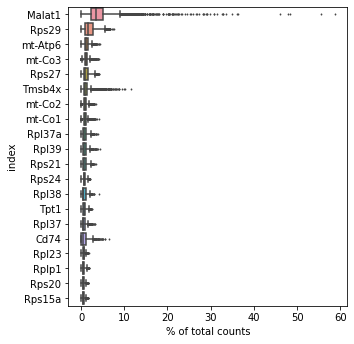

In [45]:
sc.pl.highest_expr_genes(scrna, n_top=20)

In [46]:
sc.pp.calculate_qc_metrics(scrna, percent_top=None, inplace=True)
scrna

AnnData object with n_obs × n_vars = 30474 × 13553
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

... storing 'batch' as categorical
/Users/alitinet/opt/miniconda3/envs/scvi-env/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/alitinet/opt/miniconda3/envs/scvi-env/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/alitinet/opt/miniconda3/envs/scvi-env/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/alitinet/opt/miniconda3/envs/scvi-env/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/alitinet/opt/miniconda3/envs/scvi-env/lib/python3.7/site-packages/

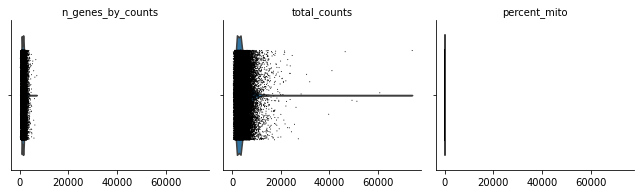

In [47]:
sc.pl.violin(scrna, ['n_genes_by_counts', 'total_counts', 'percent_mito'], jitter=0.3, multi_panel=True)

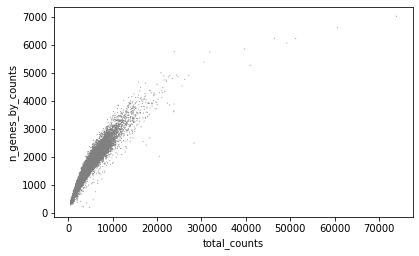

In [51]:
sc.pl.scatter(scrna, x='total_counts', y='n_genes_by_counts')

In [52]:
sc.pp.filter_cells(scrna, min_genes=100)
sc.pp.filter_genes(scrna, min_cells=3)
scrna = scrna[scrna.obs.n_genes_by_counts < 3500, :]
scrna

Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 30293 × 13553
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Normalization

In [53]:
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

/Users/alitinet/opt/miniconda3/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Highly variable genes

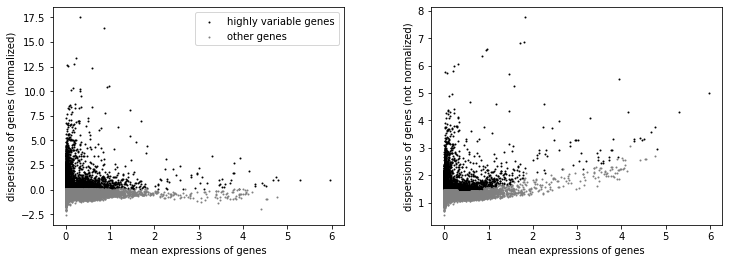

number of highly variable genes = 3999


In [54]:
sc.pp.highly_variable_genes(scrna, n_top_genes=4000)
sc.pl.highly_variable_genes(scrna)
print('number of highly variable genes =', scrna.var.highly_variable.sum())

In [55]:
scrna = scrna[:, scrna.var.highly_variable]
scrna

View of AnnData object with n_obs × n_vars = 30293 × 3999
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## Visualization

In [56]:
sc.tl.pca(scrna, random_state=0, svd_solver='arpack', n_comps=50)

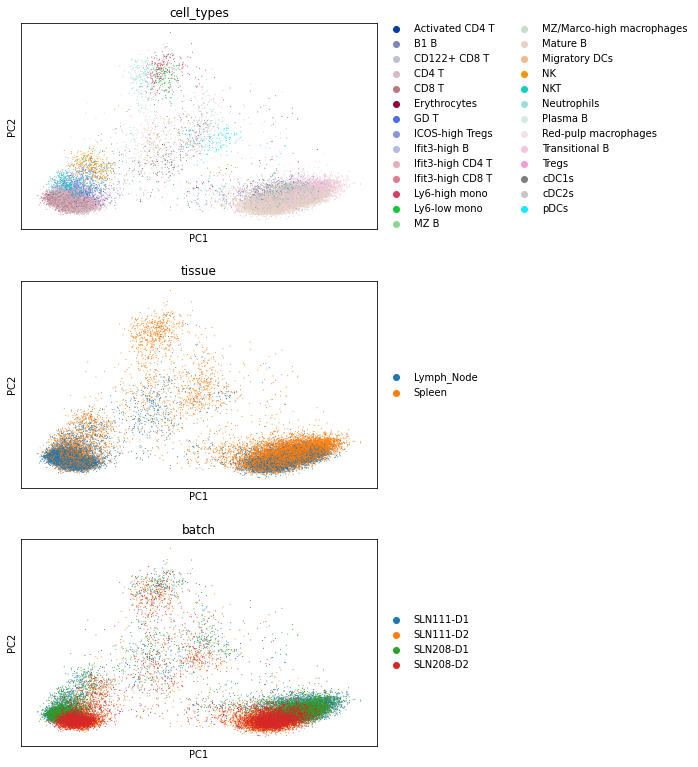

In [65]:
sc.pl.pca(scrna, color=['cell_types', 'tissue', 'batch'], ncols=1)

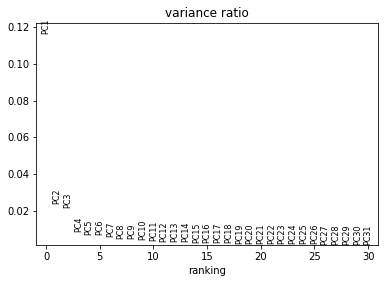

In [57]:
sc.pl.pca_variance_ratio(scrna)

In [58]:
sc.pp.neighbors(scrna, n_pcs=10)
sc.tl.umap(scrna)

In [59]:
scrna

AnnData object with n_obs × n_vars = 30293 × 3999
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

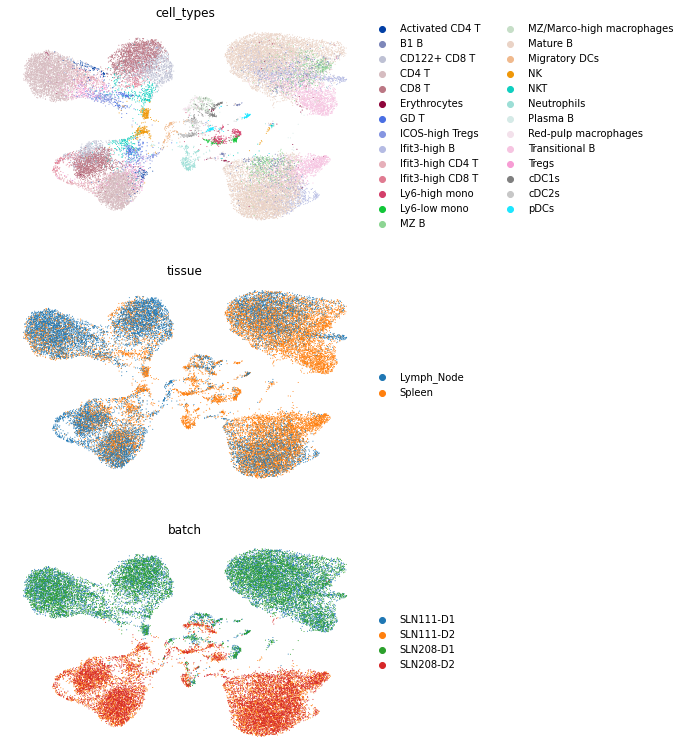

In [61]:
sc.pl.umap(scrna, color=['cell_types', 'tissue', 'batch'], frameon=False, ncols=1)

# Preprocess CITE-seq

In [66]:
sc.pp.filter_cells(cite, min_genes=1)
sc.pp.filter_genes(cite, min_cells=1)
cite

AnnData object with n_obs × n_vars = 30474 × 110
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'
    var: 'n_cells'

In [67]:
cite.raw = cite

## Quality control

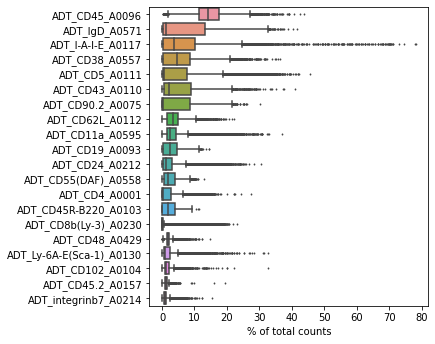

In [68]:
sc.pl.highest_expr_genes(cite, n_top=20)

## Normalization
Taken from https://github.com/theislab/scanpy/issues/1208, also discussed in https://github.com/theislab/scanpy/pull/1117.

In [70]:
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [71]:
cite = clr_normalize_each_cell(cite)

## Visualization

In [72]:
sc.tl.pca(cite, random_state=0, svd_solver='arpack', n_comps=50)

... storing 'batch' as categorical


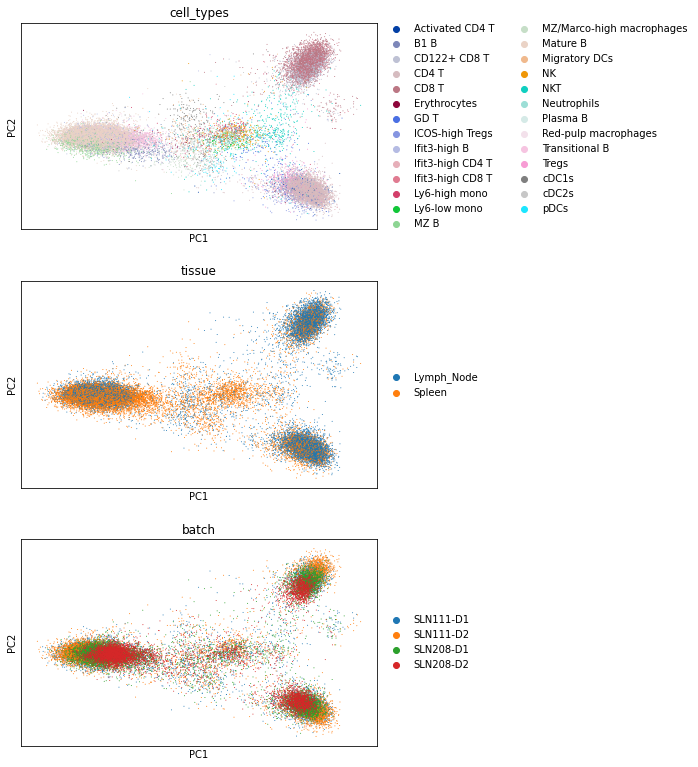

In [73]:
sc.pl.pca(cite, color=['cell_types', 'tissue', 'batch'], ncols=1)

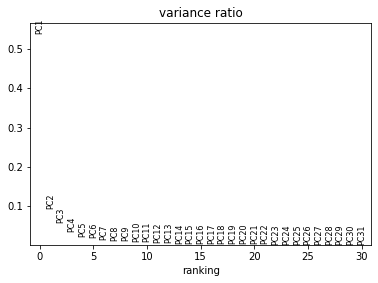

In [75]:
sc.pl.pca_variance_ratio(cite)

In [76]:
sc.pp.neighbors(cite, n_pcs=10)
sc.tl.umap(cite)

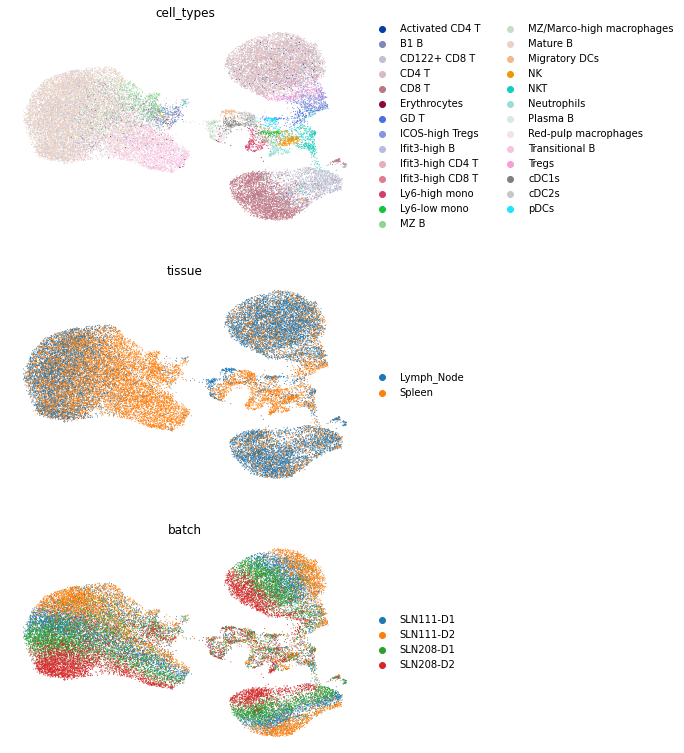

In [77]:
sc.pl.umap(cite, color=['cell_types', 'tissue', 'batch'], frameon=False, ncols=1)

# Save the results

In [78]:
com_index = set(scrna.obs.index) & set(cite.obs.index)
scrna = scrna[scrna.obs.index.isin(com_index)]
cite = cite[cite.obs.index.isin(com_index)]
print(scrna.shape, cite.shape)

(30293, 3999) (30293, 110)


In [85]:
scrna.write(SCRNA_DIR + 'expressions.h5ad')

In [86]:
cite.write(SCCITE_DIR + 'protein.h5ad')